In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpyro
numpyro.set_host_device_count(2)

In [26]:
import scipy.signal as ssig
import lalsimulation as lalsim 
import numpy as np
import jax.numpy as jnp
import jax
import arviz as az
import corner
import matplotlib.pyplot as plt

# from ripple.waveforms.IMRPhenomD import gen_IMRPhenomD_polar
from likelihood.ripple_projection import *
from ripple import ms_to_Mc_eta
from likelihood.detector_preset import * 

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value

In [27]:
psd_func_dict = {
    'H1': lalsim.SimNoisePSDaLIGOZeroDetHighPower,
    'L1': lalsim.SimNoisePSDaLIGOZeroDetHighPower,
    'V1': lalsim.SimNoisePSDAdvVirgo,
}
ifos = list(psd_func_dict.keys())

In [28]:
# define center of time array
tgps_geo = 1126259462.423

# define sampling rate and duration
fsamp = 8192
duration = 4

delta_t = 1/fsamp
tlen = int(round(duration / delta_t))

freqs = np.fft.rfftfreq(tlen, delta_t)
delta_f = freqs[1] - freqs[0]

In [29]:
# we will want to pad low frequencies; the function below applies a
# prescription to do so smoothly, but this is not really needed: you
# could just set all values below `fmin` to a constant.
fmin = 30
def pad_low_freqs(f, psd_ref):
    return psd_ref + psd_ref*(fmin-f)*np.exp(-(fmin-f))/3

psd_dict = {}
for ifo in ifos:
    psd = np.zeros(len(freqs))
    for i,f in enumerate(freqs):
        if f >= fmin:
            psd[i] = psd_func_dict[ifo](f)
        else:
            psd[i] = pad_low_freqs(f, psd_func_dict[ifo](fmin))
    psd_dict[ifo] = psd

In [30]:
rng = np.random.default_rng(12345)

noise_fd_dict = {}
for ifo, psd in psd_dict.items():
    var = psd / (4.*delta_f)  # this is the variance of LIGO noise given the definition of the likelihood function
    noise_real = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_imag = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_fd_dict[ifo] = noise_real + 1j*noise_imag

In [31]:
# These are the parameters of the injected signal
m1 = 50.0
m2 = 10.0
Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))
chi1 = 0.4
chi2 = -0.3
D = 2000.0
tc = 2.0
phic = 0.0
inclination = np.pi
psi = np.pi
ra = 0.3
dec = 0.5

params = {'Mc': Mc, 'eta': eta, 'chi1': chi1, 'chi2': chi2, 'D': D, 't_c': tc,
          'phic': phic, 'inclination': inclination, 'psi': psi, 'ra': ra, 'dec': dec}
detector_presets = {'H1': get_H1()}

In [32]:
f_list = freqs[freqs>fmin]
data = get_detector_response_ripple(f_list, params, detector_presets)
print(data)

{'H1': DeviceArray([-4.27118257e-25+4.76190789e-24j,
              3.66740642e-24-2.98849288e-24j,
             -4.66008769e-24-4.47915622e-25j, ...,
              3.32681059e-54-3.07217791e-54j,
             -3.42622122e-54+2.93455851e-54j,
              3.52006327e-54-2.79385695e-54j], dtype=complex128)}


/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


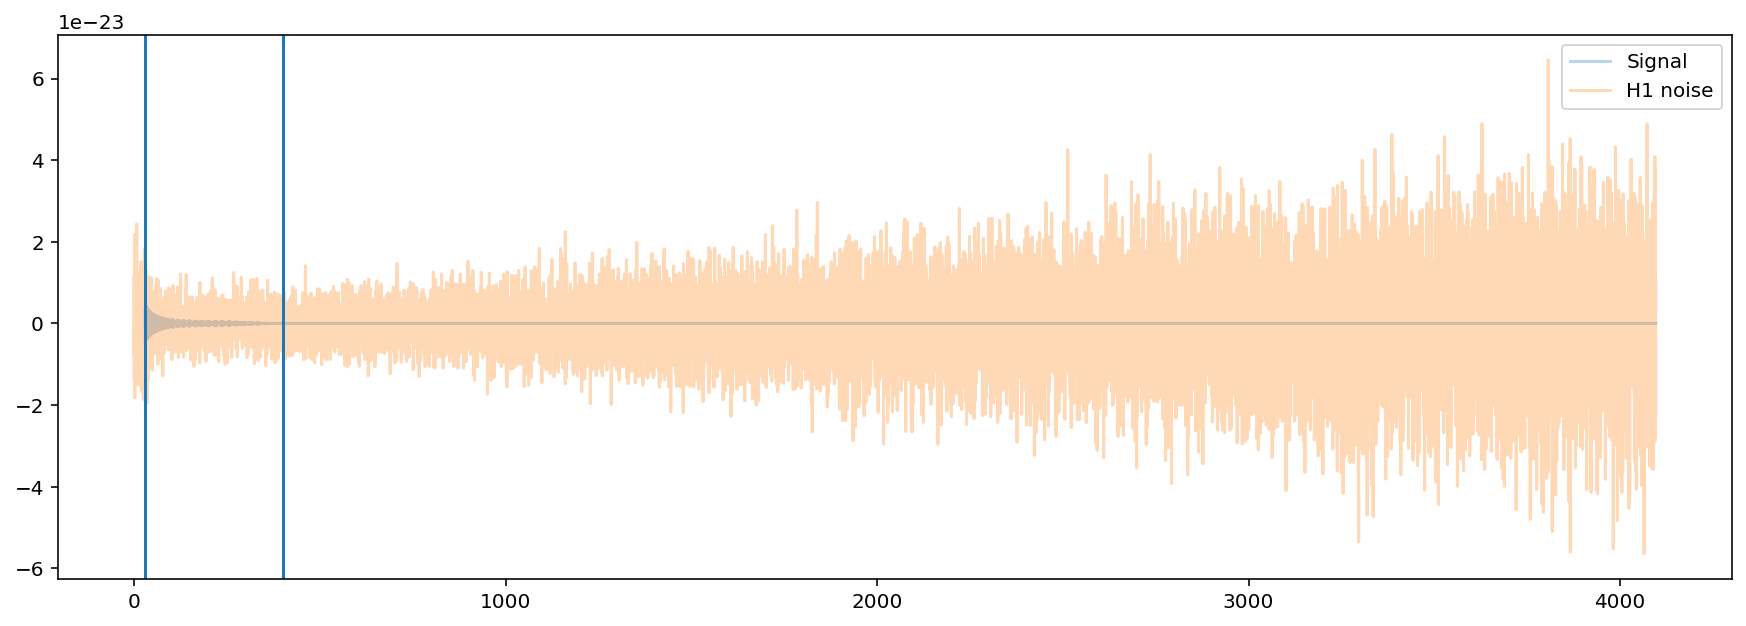

In [35]:
plt.figure(figsize=(15,5))
plt.plot(f_list, data["H1"], label="Signal", alpha=0.3)
plt.plot(freqs, noise_fd_dict["H1"], label="H1 noise", alpha=0.3)
plt.axvline(30)
plt.axvline(400)
# plt.xlim(30, 31)
plt.legend()
plt.show()

In [37]:
# Note that I'm only using frequencies above 10 Hz since the waveform generation is not 
# reliable below this
data = noise_fd_dict["H1"][freqs>fmin] + data["H1"]
var = psd_dict["H1"] / (4.*delta_f)
sigma_list = np.sqrt(var[freqs>fmin])

In [ ]:
prior_sigma_Mc = 5.0
prior_sigma_eta = 0.1
prior_sigma_chi = 5.0
prior_sigma_D = 10.0

prior_sigma_tc = 0.1
prior_sigma_phic = np.pi


def sample_uniform_sky_angle():
    U = numpyro.sample("sky_param1", dist.Uniform(0., 1.0))
    V = numpyro.sample("sky_param2", dist.Uniform(0., 1.0))
    return numpyro.deterministic("ra", 2*jnp.pi*U), numpyro.deterministic("dec", jnp.arccos(2*V - 1))

def sample_angle(name):
    phi_param = numpyro.sample("phi_param", dist.Normal(0., 1.0), sample_shape=(2,))
    return numpyro.deterministic(name, 0.5 * jnp.arctan2(phi_param[1], phi_param[0]))

def numpyro_likelihood(f, sigma, y=None):
    # Parameters of the model
    # The masses are easy
    log_Mc = numpyro.sample("log_Mc", dist.Normal(np.log(Mc), prior_sigma_Mc))
    eta_ = numpyro.sample("eta", dist.Uniform(0.0, 0.25))
    
    # Chi1 and chi2 need to e reparameterized
    chi1_ = numpyro.sample("chi1", dist.Uniform(-1., 1.))
    chi2_ = numpyro.sample("chi2", dist.Uniform(-1., 1.))
    
    # Distance prior is put into log space to ensure it stays positive
    log_D = numpyro.sample("log_D", dist.Normal(np.log(D), prior_sigma_D))
    tc_ = numpyro.sample("tc", dist.Uniform(tc-prior_sigma_tc, tc+prior_sigma_tc))
    
    # Finally, we need three angles
    # Phase of coalosences
    # Inclination Angle
    # Polarization angle
    phic_ = sample_angle("phic")
    inclination_ = sample_angle("inclination")
    psi_ = sample_angle("psi")
    
    # Now we can do the sky coordinates
    ra_, dec_ = uniform_sky_angle()
    
    params = jnp.array([jnp.exp(log_Mc), eta_, chi1_, chi2_,
                        jnp.exp(log_D), tc_, phic_, inclination_, psi_, ra_, dec_])
    waveform = get_detector_response_ripple(f_list, params, detector_presets)
    
    # Likelihood definition
    numpyro.sample(
        "real_obs", dist.Normal(waveform["H1"].real, sigma), obs=None if y is None else y.real
    )
    numpyro.sample(
        "imag_obs", dist.Normal(waveform["H1"].imag, sigma), obs=None if y is None else y.imag
    )

In [ ]:
# init = {
#     "log_Mc": np.log(Mc),
#     "eta": eta,
#     "chi1": chi1,
#     "chi2": chi2,
#     "log_D": np.log(D),
#     "tc": tc,
#     "phi_param": np.array([np.cos(phic), np.sin(phic)]),
# }
# nuts_kernel = NUTS(
#     numpyro_likelihood, dense_mass=True, target_accept_prob=0.9,
#     init_strategy=init_to_value(values=init)
# )
# mcmc = MCMC(
#     nuts_kernel,
#     num_warmup=1000,
#     num_samples=1000,
#     num_chains=2,
#     progress_bar=True,
# )
# rng_key = jax.random.PRNGKey(34923)

# mcmc.run(rng_key, f_list[:1500], sigma_list[:1500], y=data[:1500])
# samples = mcmc.get_samples()